aggiungere https://www.istat.it/it/metodi-e-strumenti/web-service-sdmx

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from IPython.core.pylabtools import figsize
figsize(15, 5)
def calc_larg(val):

    val_sep = val.split("-")
    l = (int(val_sep[1]) - int(val_sep[0]))
    return l


def scale(x, sf, scalepars_min_x=None, scalepars_max_xp=None):
    if scalepars_min_x is None:
        scalepars_min_x = np.min(x)
    x_sc = x-scalepars_min_x
    if scalepars_max_xp is None:
        scalepars_max_xp = np.max(x_sc)
    x_sc = x_sc/scalepars_max_xp
    x_sc *= sf
    return x_sc, scalepars_min_x, scalepars_max_xp


def scale_back(x, scalepars_min_x, scalepars_max_xp):    
    x_sc = x/np.max(x)
    x_sc *= scalepars_max_xp
    x_sc = x_sc+scalepars_min_x
    return x_sc

def calc_sq_diff(a, b):
    return np.sum(np.square(a-b))

no_tax = 8.174
scaglioni = np.array([ 0, 15, 28, 55, 75])
aliquote = np.array([ .23, .27, .38, .41, .43])
base = np.array([ 0, 3.450, 6.960, 17.220, 25.420])

def calc_irpef(reddito, solo_aliquota = False):
    if reddito <= no_tax:
        return 0
    
    for i_s, s in enumerate( scaglioni):
        b = base[i_s-1]
        a = aliquote[i_s-1]
        #a = aliquote[i_s]
        if reddito > s:
        #if reddito > scaglioni[i_s +1] :
            continue
            
        else:
            #print ("reddito", reddito, "scaglione", s, "aliquota", a, "base", b, "sttraggo", scaglioni[i_s-1])
            if not solo_aliquota:
                return  b + a * (reddito - scaglioni[i_s-1])
            else:
                return a
    return base[-1] + aliquote[-1] * (reddito - scaglioni[-1])

## Studio redditi dichiarati

In [90]:
# file preso da https://www1.finanze.gov.it/finanze3/analisi_stat/index.php?tree=2018AAPFTOT020602&export=0&media=media&page=1&personalizza=no
'''Tipo di imposta : IRPEF

Modello : Persone fisiche totali

Tipologia contribuente : Tutte le tipologie di contribuenti

Tematica : Calcolo dell'IRPEF

Classificazione : Classi di reddito complessivo in euro

Ammontare e media espressi in : Migliaia di euro
'''
df = pd.read_csv("irpef2.csv", delimiter=";", decimal=",", thousands=".")


In [91]:
'''def calc_vc(val):

    val_sep = val.split("-")
    vc = (int(val_sep[1]) - int(val_sep[0]))/2 + int(val_sep[0])
    return vc
df["valore_centrale"] = df['Codice'].apply(calc_vc)'''


df["larghezza"] = df['Codice'].apply(calc_larg)
#df = df[df['Reddito complessivo - Media']<100]

In [92]:
colonne_interessanti = ['Classi di reddito complessivo in euro', 
                        'Numero contribuenti', 
                        'Reddito complessivo - Ammontare',
                       'Reddito complessivo - Media', 'larghezza']
df = df[colonne_interessanti]

display(df.head())
df['Reddito complessivo - Ammontare scalato'] = df['Reddito complessivo - Ammontare'] / 1000000


,Classi di reddito complessivo in euro,Numero contribuenti,Reddito complessivo - Ammontare,Reddito complessivo - Media,larghezza
0,da 0 a 1.000,2350042,991408,0.42,1000
1,da 1.000 a 1.500,606558,753107,1.24,500
2,da 1.500 a 2.000,507765,887646,1.75,500
3,da 2.000 a 2.500,466449,1051872,2.26,500
4,da 2.500 a 3.000,437705,1203420,2.75,500


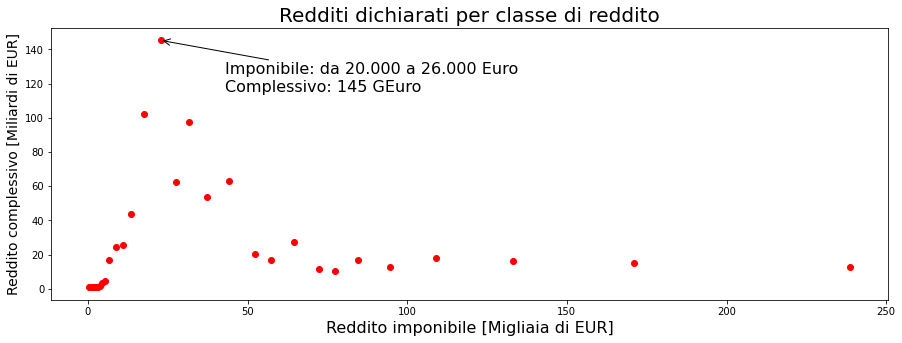

In [93]:
plt.plot(df['Reddito complessivo - Media'], df["Reddito complessivo - Ammontare scalato"], 'ro')


max_at_pos = np.argmax (df["Reddito complessivo - Ammontare scalato"])
x_at_max = df['Reddito complessivo - Media'][max_at_pos]
calsse_x_at_max = df['Classi di reddito complessivo in euro'][max_at_pos]
y_at_max = df["Reddito complessivo - Ammontare scalato"][max_at_pos]
plt.annotate(f"Imponibile: {calsse_x_at_max} Euro\nComplessivo: {int(y_at_max)} GEuro", 
             [x_at_max, y_at_max], 
             xytext=(x_at_max+20, y_at_max-30), 
             arrowprops=dict(arrowstyle="->"),
            size=16)
plt.xlabel("Reddito imponibile [Migliaia di EUR]", size = 16)
plt.ylabel("Reddito complessivo [Miliardi di EUR]", size = 14)
plt.title("Redditi dichiarati per classe di reddito", size=20)
plt.show()

In [105]:
df = df[df['Reddito complessivo - Media']<100]
df['area_loc'] = df["larghezza"]* df["Reddito complessivo - Ammontare scalato"]
area_tot = np.sum(df['area_loc'])
area_tot

4200438.836499999

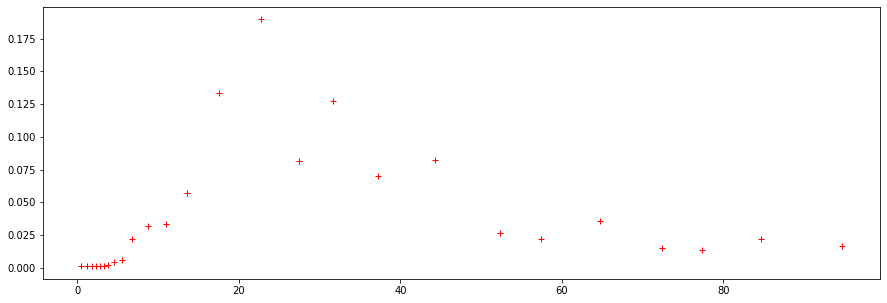

In [106]:
y_norm =  df["Reddito complessivo - Ammontare scalato"]/area_tot
plt.plot(df['Reddito complessivo - Media'], y_norm/np.sum(y_norm), 'r+')

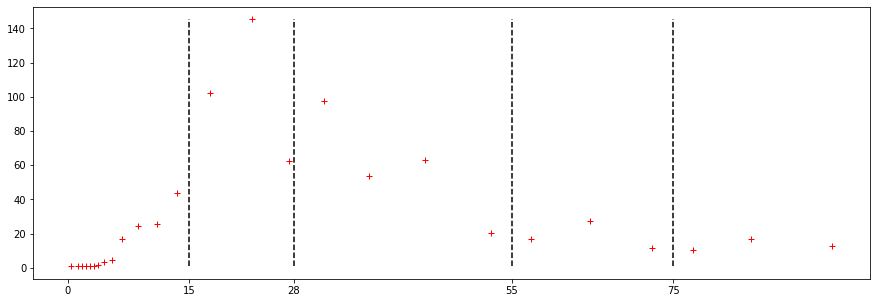

In [107]:
y4plot = df["Reddito complessivo - Ammontare scalato"]#/1e8+2
plt.plot(df['Reddito complessivo - Media'], y4plot, 'r+')

max_y = np.max(y4plot)
min_y = np.min(y4plot)
plt.xticks(scaglioni)
for s in scaglioni:
    if s == 0:
        continue
    plt.plot([s, s], [min_y, max_y], '--', color = 'k')


/Users/vincenzo/opt/miniconda3/envs/py39/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


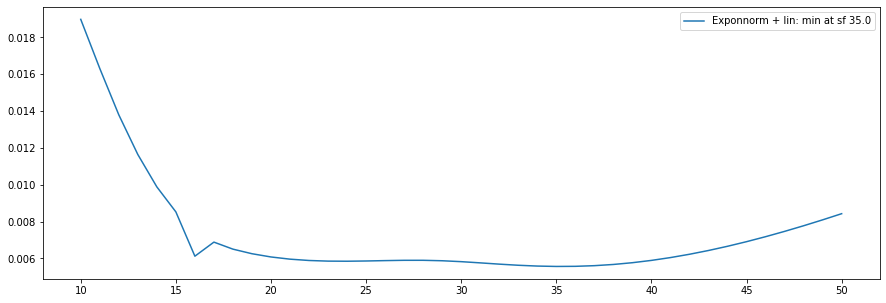

minimo in pos 25: scalato a 35.0 , valore: 0.005567674221393899


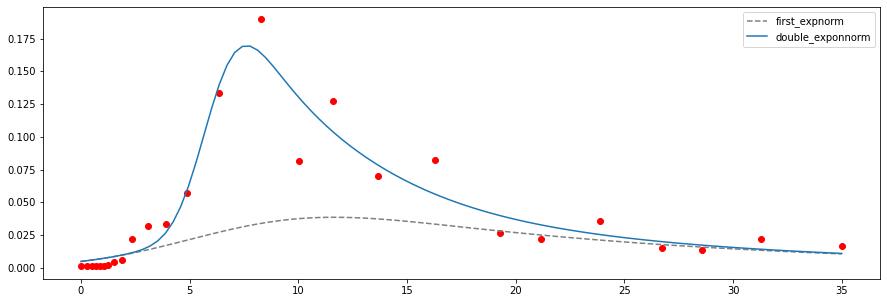

In [108]:
def double_exponnorm(x, p0, p1, p2, p3):
    return stats.exponnorm.pdf(x,  p0, p1, p2) + stats.exponnorm.pdf(x,  p0, p1, p3)

rescaled = np.linspace (10, 50, 41)

sq_errs = []
y2use = y_norm/np.sum(y_norm)
last = 100
tutti_pars = []
for sf in rescaled:
    x_sc, _, _ = scale(df['Reddito complessivo - Media'], sf)
    initial = [5, 3, 0.8, 0.4]
    try:
        pars, cov = curve_fit(double_exponnorm, x_sc, y2use, p0 = initial)#, bounds=bounds)
        tutti_pars .append(pars)
        sq_err = calc_sq_diff(double_exponnorm(x_sc, pars[0], pars[1], pars[2], pars[3]), y2use)
        sq_errs.append(sq_err)
        last = sq_err
    except RuntimeError:
        sq_errs.append(last)
min_at=np.argmin(sq_errs)
sf_scelto = rescaled[min_at]
errore = sq_errs[min_at]
pars_scelti = tutti_pars[min_at]

plt.plot(rescaled, sq_errs, label = f"Exponnorm + lin: min at sf {sf_scelto}")
plt.legend()
plt.show()


print (f"minimo in pos {min_at}: scalato a {sf_scelto} , valore: {errore}")

xt = np.linspace(0, sf_scelto, 100)
y1 = stats.exponnorm.pdf(xt, pars_scelti[0], pars_scelti[1], pars_scelti[2])
yt = double_exponnorm(xt, pars_scelti[0], pars_scelti[1], pars_scelti[2], pars_scelti[3])

plt.plot(xt, y1, '--', label='first_expnorm', color = 'grey')
plt.plot(xt, yt, label="double_exponnorm")

x_sc, sc_min, sc_max = scale(df['Reddito complessivo - Media'], sf_scelto)
plt.scatter(x_sc, y2use, color='r')
plt.legend()
plt.show()



In [142]:
np.isclose(xt, 3, atol=0.2)

array([False, False, False, False, False, False, False, False,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [159]:
xt_raw = np.linspace(0, df['Reddito complessivo - Media'].values[-1], 1000)
x_loc = [np.argmax(np.isclose(xt_raw, val, atol=0.055)) for val in df['Reddito complessivo - Media'].values]
xt = xt_raw/df['Reddito complessivo - Media'].values[-1]*sf_scelto

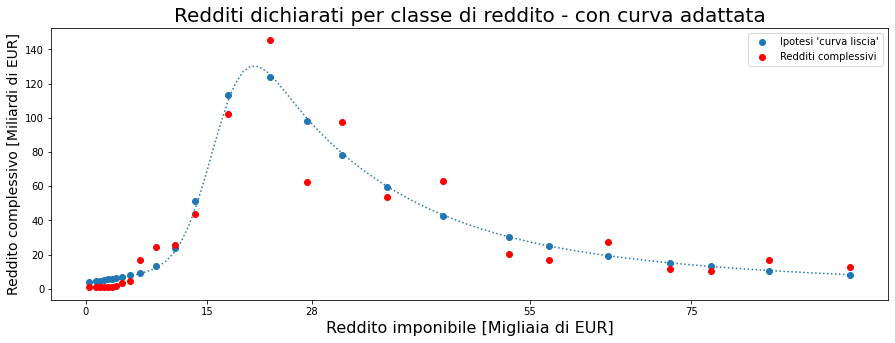

In [174]:
xt = np.linspace(0, sf_scelto, 100)
x_las = df['Reddito complessivo - Media'].values/df['Reddito complessivo - Media'].values[-1]*sf_scelto
xt = np.sort(np.concatenate([xt, x_las]))
xt_sc_b = scale_back(xt, sc_min, sc_max)

yt = double_exponnorm(xt, pars_scelti[0], pars_scelti[1], pars_scelti[2], pars_scelti[3])
y_scale_bac_fac = area_tot * np.sum(y_norm)

plt.plot(xt_sc_b, yt*y_scale_bac_fac, ":")
y_atteso = double_exponnorm(x_las, pars_scelti[0], pars_scelti[1], pars_scelti[2], pars_scelti[3])
plt.scatter(df['Reddito complessivo - Media'], y_atteso*y_scale_bac_fac, label="Ipotesi 'curva liscia'", marker='o')

plt.scatter(df['Reddito complessivo - Media'], df["Reddito complessivo - Ammontare scalato"], label="Redditi complessivi", color='r')
plt.legend()
plt.xlabel("Reddito imponibile [kEUR]")
plt.ylabel("Reddito complessivo [kEUR]")
max_y = np.max(y2use)
min_y = np.min(y2use)
plt.xticks(scaglioni)
for s in scaglioni:
    if s == 0:
        continue
    #plt.plot([s, s], [min_y*y_scale_bac_fac, 1.2e8], '.-', color = 'gray')
    plt.xlabel("Reddito imponibile [Migliaia di EUR]", size = 16)
plt.ylabel("Reddito complessivo [Miliardi di EUR]", size = 14)
plt.title("Redditi dichiarati per classe di reddito - con curva adattata", size=20)
plt.show()

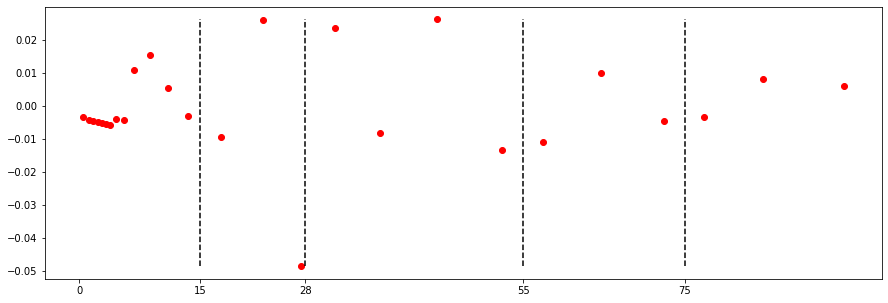

In [173]:
#pars_scelti = np.array([3.69957129, 5.87470515, 4.25561841, 1.2146135 ])

baseline =  double_exponnorm(x_sc, pars_scelti[0], pars_scelti[1], pars_scelti[2], pars_scelti[3])
dati_m_baseline = y2use - baseline
x_sc_b = scale_back(x_sc, sc_min, sc_max)
plt.scatter(x_sc_b, dati_m_baseline, color='r', marker='o')
max_y = np.max(dati_m_baseline)
min_y = np.min(dati_m_baseline)
plt.xticks(scaglioni)
for s in scaglioni:
    if s == 0:
        continue
    plt.plot([s, s], [min_y, max_y], '--', color = 'k')
plt.show()

## da scaglioni a continua

con fit prima tanh su range 0 200 : gettito vecchio: 226.047, gettito nuovo: 226.047


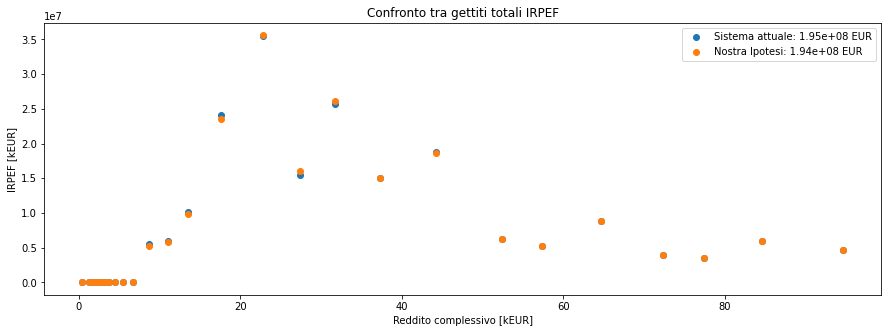

In [73]:
def mia_tanh(x, p0, p1, p2):
    return p0+p1*np.tanh(p2+x)


def mia_norm(x, p0, p1, p2, p3):
    return p0 * stats.norm.pdf (x, p1, p2) - p3


def calc_nuovissima_irpef(x, p0=27.42923408, p1=42.5570628, p2=-0.79495414, p3=5.158, p4=8.1, p5=4.9, p6=0.015):
    zeros = x>no_tax
    x_scaled, _, _ = scale(x, 1, 0, 100 )
    
    f1 = mia_tanh(x_scaled, p0, p1, p2)
    f2 = mia_norm(x, p3, p4, p5, p6)
        
    calculated = (f1+f2) * zeros

    
    tokeep_pos = np.argmin(x<75)
    high_income = []
    for data in x[tokeep_pos:]:
        high_income.append(calc_irpef(data))

    # eliminiamo discontinuità
    last_tokeep = calculated[tokeep_pos]
    salto = last_tokeep-high_income[0]
    high_income += salto
    exp_calc = np.concatenate([calculated[:tokeep_pos], high_income])
    return exp_calc


irpef_tot_attuali = []
irpef_tot_continua = calc_nuovissima_irpef(df['Reddito complessivo - Media'].values)
nc = df['Numero contribuenti'].values

for i_rcm, rcm in df['Reddito complessivo - Media'].iteritems():
    irpef_tot_attuali.append(calc_irpef(rcm))

plt.scatter(df['Reddito complessivo - Media'], irpef_tot_attuali*nc, label = f'Sistema attuale: {np.sum(irpef_tot_attuali*nc):2.2e} EUR')
plt.scatter(df['Reddito complessivo - Media'], irpef_tot_continua*nc, label = f'Nostra Ipotesi: {np.sum(irpef_tot_continua*nc):2.2e} EUR')

plt.xlabel("Reddito complessivo [kEUR]")
plt.ylabel("IRPEF [kEUR]")
plt.title("Confronto tra gettiti totali IRPEF")
print (f"con fit prima tanh su range 0 200 : gettito vecchio: {np.sum(irpef_tot_attuali):3.3f}, gettito nuovo: {np.sum(irpef_tot_continua):3.3f}")  #
plt.legend()

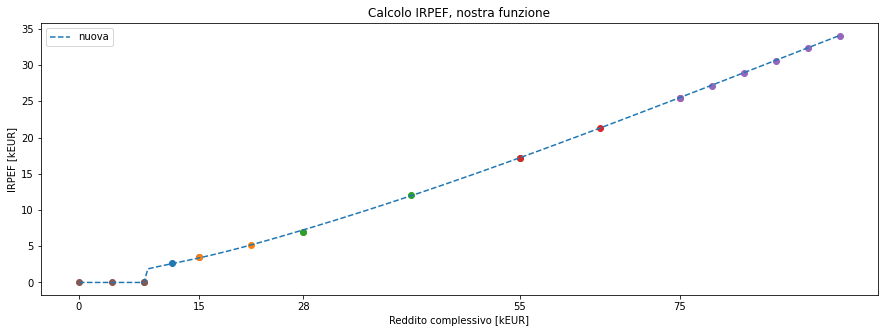

In [74]:
con_func = True
max_red = 95 # np.max(df['Reddito complessivo - Media']

for i_sc, scaglione in enumerate(scaglioni):
    if i_sc<4:
        x = np.linspace(np.max([scaglione, no_tax]), scaglioni[i_sc+1], 3)
    elif i_sc == 4:
        x = np.linspace(scaglioni[-1], max_red, 6)
    else:
        x = np.linspace(0, no_tax, 2)
    y = []
    for x_i in x:
        y.append(calc_irpef(x_i))
    plt.scatter(x, y)
    
x = np.linspace(0, no_tax, 3)
y = []
for x_i in x:
    y.append(calc_irpef(x_i))
plt.scatter(x, y)
    
    
    
if con_func:
    ascisse_cont = np.linspace(0, max_red, 200) 
    nuova_irpef = (calc_nuovissima_irpef(ascisse_cont))
    plt.plot(ascisse_cont, nuova_irpef, '--', label='nuova')

    
plt.xlabel("Reddito complessivo [kEUR]")
plt.ylabel("IRPEF [kEUR]")
if con_func:
    plt.title("Calcolo IRPEF, nostra funzione")
else:
    plt.title("Calcolo IRPEF, sistema attuale")
plt.legend()
plt.xticks(scaglioni)
plt.show()

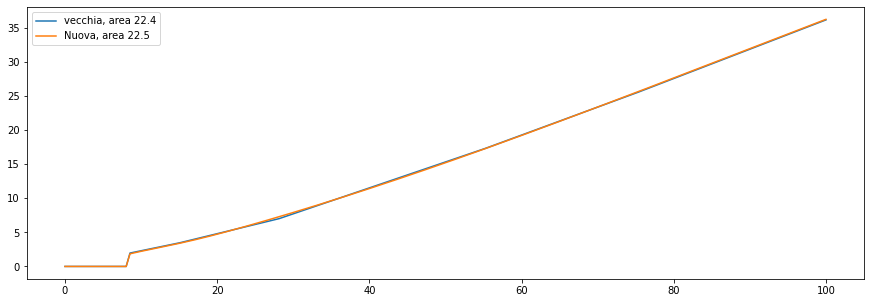

differenza alla coda: -0.22239119492940382


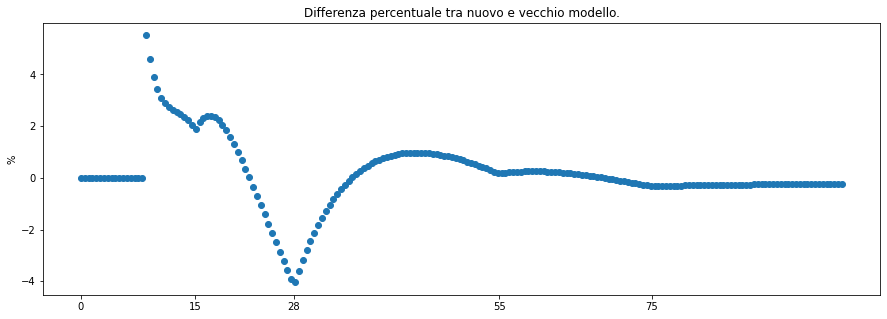

In [75]:
x = np.linspace(0, 100, 200)
y = []
for x_i in x:
    y.append(calc_irpef(x_i))
y = np.array(y)
area_vecchia = np.sum(y * x)/10000
plt.plot(x, y, label = f"vecchia, area {area_vecchia:3.1f}")

nuova_irpef =  calc_nuovissima_irpef(x)
area_nuova = np.sum(nuova_irpef *x)/10000
plt.plot(x,nuova_irpef, label = f"Nuova, area {area_nuova:3.1f}")
plt.legend()
#plt.xlim(26, 30)
#plt.ylim(5, 10)
plt.show()


y_diff=100*np.divide((y - nuova_irpef), y, where= y>0)
#y_diff =( y - nuova_irpef)/y
plt.scatter(x, y_diff)
plt.title("Differenza percentuale tra nuovo e vecchio modello.")
plt.ylabel ("%")
plt.xticks(scaglioni)

print (f"differenza alla coda: {y_diff[-1]}")